# TF-IDF Content-Based Recommendation on the COVID-19 Open Research Dataset

In [1]:
import sys
from recommenders.datasets import covid_utils
from recommenders.models.tfidf.tfidf_utils import TfidfRecommender
print(sys.version)

3.7.13 (default, Mar 29 2022, 02:18:16) 
[GCC 7.5.0]


## 1. Load the dataset into a dataframe

In [2]:
container_name = 'covid19temp'
metadata_filename = 'metadata.csv'
sas_token = '' # please see Azure Open Datasets notebook for SAS token

metadata = covid_utils.load_pandas_df(container_name=container_name,
                                     metadata_filename=metadata_filename,
                                     azure_storage_sas_token=sas_token)
# https://azureopendatastorage.blob.core.windows.net/covid19temp/metadata.csv

/home/qwer/anaconda3/envs/recommender3713/lib/python3.7/site-packages/ipykernel_launcher.py:7: DtypeWarning: Columns (13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  import sys


## 2. Extract articles in the public domain
We will only be using articles that fall under the public domain,

<AxesSubplot:title={'center':'License'}>

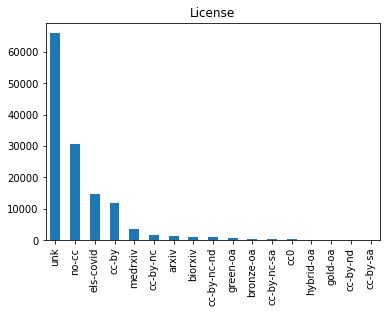

In [5]:
metadata['license'].value_counts().plot(kind='bar', title='License')

In [3]:
# Extract public domain articles only and Clean dataframe
# : Remove duplicated rows ans None values in specified("cord_uid", "doi", "title", "license", "url") columns
meta_public = metadata.loc[metadata['license']=='cc0']
meta_public = covid_utils.clean_dataframe(meta_public)

print('Number of articles in dataset: ' + str(len(metadata)))
print('Number of articles in dataset that fall under the public domain (cc0): ' + str(len(meta_public)))
meta_public.head()

Number of articles in dataset: 134206
Number of articles in dataset that fall under the public domain (cc0): 274


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ej795nks,a3c3b7c38ad32e1042d78aae2027ca491e9f2197,PMC,Understanding the Spatial Clustering of Severe...,10.1289/ehp.7117,PMC1247620,15531441.0,cc0,We applied cartographic and geostatistical met...,2004-07-27,"Lai, P.C.; Wong, C.M.; Hedley, A.J.; Lo, S.V.;...",Environ Health Perspect,NaN,NaN,NaN,document_parses/pdf_json/a3c3b7c38ad32e1042d78...,document_parses/pmc_json/PMC1247620.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,NaN
1,9mzs5dl4,c1c6a98c21304f3788b20870b34afd8a115fa38c,PMC,The Application of the Haddon Matrix to Public...,10.1289/ehp.7491,PMC1257548,15866764.0,cc0,State and local health departments continue to...,2005-02-02,"Barnett, Daniel J.; Balicer, Ran D.; Blodgett,...",Environ Health Perspect,NaN,NaN,NaN,document_parses/pdf_json/c1c6a98c21304f3788b20...,document_parses/pmc_json/PMC1257548.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,NaN
2,u7lz3spe,c56ffdaf1cfbae5a6ed0abea495eaf7fa1cbc031,PMC,Cynomolgus Macaque as an Animal Model for Seve...,10.1371/journal.pmed.0030149,PMC1435788,16605302.0,cc0,BACKGROUND: The emergence of severe acute resp...,2006-04-18,"Lawler, James V; Endy, Timothy P; Hensley, Lis...",PLoS Med,NaN,NaN,NaN,document_parses/pdf_json/c56ffdaf1cfbae5a6ed0a...,document_parses/pmc_json/PMC1435788.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,NaN
3,na7z92i8,f38f3b112e4b702b60ba56be806d418bbb2b83c3,PMC,Immune Protection of Nonhuman Primates against...,10.1371/journal.pmed.0030177,PMC1459482,16683867.0,cc0,BACKGROUND: Ebola virus causes a hemorrhagic f...,2006-05-16,"Sullivan, Nancy J; Geisbert, Thomas W; Geisber...",PLoS Med,NaN,NaN,NaN,document_parses/pdf_json/f38f3b112e4b702b60ba5...,document_parses/pmc_json/PMC1459482.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,NaN
4,j35w1vsw,5dc0b8b662824323881c3a1ae3a1bae2a821484d,PMC,SARS: Systematic Review of Treatment Effects,10.1371/journal.pmed.0030343,PMC1564166,16968120.0,cc0,BACKGROUND: The SARS outbreak of 2002–2003 pre...,2006-09-12,"Stockman, Lauren J; Bellamy, Richard; Garner, ...",PLoS Med,NaN,NaN,NaN,document_parses/pdf_json/5dc0b8b662824323881c3...,document_parses/pmc_json/PMC1564166.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,NaN


## Retrieve full article text

In [4]:
# Extract text from all public domain articles
all_text = covid_utils.get_public_domain_text(df=meta_public,
                                             container_name=container_name,
                                             azure_storage_sas_token=sas_token)
all_text.head()

,index,cord_uid,doi,title,publish_time,authors,journal,url,abstract,full_text
0,0,ej795nks,10.1289/ehp.7117,Understanding the Spatial Clustering of Severe...,2004-07-27,"Lai, P.C.; Wong, C.M.; Hedley, A.J.; Lo, S.V.;...",Environ Health Perspect,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,We applied cartographic and geostatistical met...,Since the emergence and rapid spread of the et...
1,1,9mzs5dl4,10.1289/ehp.7491,The Application of the Haddon Matrix to Public...,2005-02-02,"Barnett, Daniel J.; Balicer, Ran D.; Blodgett,...",Environ Health Perspect,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,State and local health departments continue to...,"sudden fever and dry cough, along with chills ..."
2,2,u7lz3spe,10.1371/journal.pmed.0030149,Cynomolgus Macaque as an Animal Model for Seve...,2006-04-18,"Lawler, James V; Endy, Timothy P; Hensley, Lis...",PLoS Med,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,BACKGROUND: The emergence of severe acute resp...,The emergence of severe acute respiratory synd...
3,3,na7z92i8,10.1371/journal.pmed.0030177,Immune Protection of Nonhuman Primates against...,2006-05-16,"Sullivan, Nancy J; Geisbert, Thomas W; Geisber...",PLoS Med,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,BACKGROUND: Ebola virus causes a hemorrhagic f...,Background Ebola virus causes a hemorrhagic fe...
4,4,j35w1vsw,10.1371/journal.pmed.0030343,SARS: Systematic Review of Treatment Effects,2006-09-12,"Stockman, Lauren J; Bellamy, Richard; Garner, ...",PLoS Med,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,BACKGROUND: The SARS outbreak of 2002–2003 pre...,The SARS outbreak of 2002-2003 presented clini...


## Instantiate the recommender
데이터 전처리와 추천을 위한 모든 함수는 `TfidfRecommender` 클래스에 포함되어 있다. 이 함수들을 실행시키기 전에 오브젝트를 만들어줘야 한다.   
모델에서 사용할 토큰화 방법을 다음 중 고른다.
- `none` : 토큰화를 적용하지 않는다. 각 단어 자체가 토큰으로 사용된다.
- `nltk` : NLTK를 이용해서 간단한 stemming을 적용한다
- `bert` : HuggingFace BERT 토큰화를 적용한다.('bert-base-cased')
- `scibert` : SciBERT 토큰화를 적용하는데, 이 방법은 과학 기사에 추천하는 방법이다. ('allenai/scibert_scivocab_cased') 

In [5]:
# recommender object
recommender = TfidfRecommender(id_col='cord_uid', tokenization_method='scibert')

## Prepare text for use in the TF-IDF recommender

In [6]:
# Preview the first 1000 chars
print(all_text['full_text'][0][:1000])

Since the emergence and rapid spread of the etiologic agent of severe acute respiratory syndrome (SARS)-SARS coronavirus (SARS-CoV)-in late 2002 and during the first 6 months of 2003, great progress has been made in understanding the biology, pathogenesis, and epidemiology of both the disease and the virus (SARS-CoV). Much remains to be done, however, including the development of effective therapeutic interventions and diagnostic tools with high sensitivity and specificity soon after the onset of clinical symptoms. The evaluation of key epidemiologic parameters and the impact of different public health interventions in the various settings that experienced minor or major epidemics is also needed (Affonso et al. 2004; Cui et al. 2003; Lau et al. 2004; Leung et al., in press) . In terms of outbreak control on the population level, many questions about "superspreading events" (SSEs) remain to be investigated. Such an SSE was responsible for > 300 cases (out of a total of 1,755) in the Amo

In [7]:
cols_to_clean = ['title', 'abstract', 'full_text']
df_clean = recommender.clean_dataframe(all_text, cols_to_clean, 'cleaned_text')
df_clean.head()

,index,cord_uid,doi,title,publish_time,authors,journal,url,abstract,full_text,cleaned_text
0,0,ej795nks,10.1289/ehp.7117,Understanding the Spatial Clustering of Severe...,2004-07-27,"Lai, P.C.; Wong, C.M.; Hedley, A.J.; Lo, S.V.;...",Environ Health Perspect,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,We applied cartographic and geostatistical met...,Since the emergence and rapid spread of the et...,Understanding the Spatial Clustering of Severe...
1,1,9mzs5dl4,10.1289/ehp.7491,The Application of the Haddon Matrix to Public...,2005-02-02,"Barnett, Daniel J.; Balicer, Ran D.; Blodgett,...",Environ Health Perspect,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,State and local health departments continue to...,"sudden fever and dry cough, along with chills ...",The Application of the Haddon Matrix to Public...
2,2,u7lz3spe,10.1371/journal.pmed.0030149,Cynomolgus Macaque as an Animal Model for Seve...,2006-04-18,"Lawler, James V; Endy, Timothy P; Hensley, Lis...",PLoS Med,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,BACKGROUND: The emergence of severe acute resp...,The emergence of severe acute respiratory synd...,Cynomolgus Macaque as an Animal Model for Seve...
3,3,na7z92i8,10.1371/journal.pmed.0030177,Immune Protection of Nonhuman Primates against...,2006-05-16,"Sullivan, Nancy J; Geisbert, Thomas W; Geisber...",PLoS Med,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,BACKGROUND: Ebola virus causes a hemorrhagic f...,Background Ebola virus causes a hemorrhagic fe...,Immune Protection of Nonhuman Primates against...
4,4,j35w1vsw,10.1371/journal.pmed.0030343,SARS: Systematic Review of Treatment Effects,2006-09-12,"Stockman, Lauren J; Bellamy, Richard; Garner, ...",PLoS Med,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,BACKGROUND: The SARS outbreak of 2002–2003 pre...,The SARS outbreak of 2002-2003 presented clini...,SARS Systematic Review of Treatment Effects BA...


In [8]:
# Tokenize the cleaned text, the tokens are stored within our TfidfRecommender object
tf, vectors_tokenized = recommender.tokenize_text(df_clean, text_col='cleaned_text')

In [9]:
vectors_tokenized

0      understanding the spatial clustering of severe...
1      the application of the had ##don matrix to pub...
2      cy ##no ##mol ##gu ##s mac ##aque as an animal...
3      immune protection of non ##human primates agai...
4      sa ##rs systematic review of treatment effects...
                             ...                        
252    a broadly neutralizing germline ##like human m...
253    three ##dimensional normal human neural progen...
254    antimicrobial activity of bovine nk ##lys ##in...
255    contamination of hospital surfaces with respir...
256    damaged ##anger associated molecular patterns ...
Name: cleaned_text, Length: 257, dtype: object

## Recommend articles using TF-IDF
Now fit the recommender model to the processed data and retrieve the top-k recommended articles.
- `cord_uid` corresponds to the article that is being used to make recommendations from
- `rec_rank` contains the recommendations rank
- `rec_score` is the cosine similarity score between the query article and the recommended article
- `rec_cord_uid` corresponds to the recommended article.

In [10]:
recommender.fit(tf, vectors_tokenized)
top_k_rec = recommender.recommend_top_k_items(df_clean, k=5)
top_k_rec

,cord_uid,rec_rank,rec_score,rec_cord_uid
0,ej795nks,1,0.142033,u7lz3spe
1,ej795nks,2,0.117743,j35w1vsw
2,ej795nks,3,0.100325,nt60lv2k
3,ej795nks,4,0.076779,vp9d9vmp
4,ej795nks,5,0.074392,05d1mhkq
...,...,...,...,...
1280,yetdnv6j,1,0.048499,9w9w0z4o
1281,yetdnv6j,2,0.046675,6nas74q1
1282,yetdnv6j,3,0.044476,7docv0dt
1283,yetdnv6j,4,0.040522,oj60pldq


In [11]:
df_clean[df_clean['cord_uid']=='ej795nks']['cleaned_text'][0]

'Understanding the Spatial Clustering of Severe Acute Respiratory Syndrome SARS in Hong Kong We applied cartographic and geostatistical methods in analyzing the patterns of disease spread during the 2003 severe acute respiratory syndrome SARS outbreak in Hong Kong using geographic information system GIS technology We analyzed an integrated database that contained clinical and personal details on all 1755 patients confirmed to have SARS from 15 February to 22 June 2003 Elementary mapping of disease occurrences in space and time simultaneously revealed the geographic extent of spread throughout the territory Statistical surfaces created by the kernel method confirmed that SARS cases were highly clustered and identified distinct disease hot spots Contextual analysis of mean and standard deviation of different density classes indicated that the period from day 1 18 February through day 16 6 March was the prodrome of the epidemic whereas days 86 15 May to 106 4 June marked the declining pha

In [12]:
# Access the full recommendation dictionary
# which contains full ranked lists for each public domain article
full_rec_list = recommender.recommendations
article_of = 'ej795nks'
print('Number of recommended articles for ' + article_of + ': ' + str(len(full_rec_list[article_of])))

Number of recommended articles for ej795nks: 256


In [14]:
# Also can view the tokens and stop words
# which were used in the recommender
tokens = recommender.get_tokens()
print('Tokens :', list(tokens.keys())[:10])

stop_words = list(recommender.get_stop_words())
stop_words.sort()
print(stop_words[:10])

Tokens : ['understanding', 'spatial', 'clustering', 'severe', 'acute', 'respiratory', 'syndrome', 'sa', 'rs', 'hon']
['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost']


## 7. Display top recommendations for article of interest
이제 주어진 기사에 대해 top-k 추천의 전체적인 메타데이터를 볼 수 있다.

In [15]:
cols_to_keep = ['title','authors','journal','publish_time','url']
recommender.get_top_k_recommendations(meta_public, article_of, cols_to_keep)

,rank,similarity_score,title,authors,journal,publish_time,url
0,1,0.142033,Cynomolgus Macaque as an Animal Model for Severe Acute Respiratory Syndrome,"Lawler, James V; Endy, Timothy P; Hensley, Lisa E; Garrison, Aura; Fritz, Elizabeth A; Lesar, May; Baric, Ralph S; Kulesh, David A; Norwood, David A; Wasieloski, Leonard P; Ulrich, Melanie P; Slezak, Tom R; Vitalis, Elizabeth; Huggins, John W; Jahrling, Peter B; Paragas, Jason",PLoS Med,2006-04-18,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1435788/
1,2,0.117743,SARS: Systematic Review of Treatment Effects,"Stockman, Lauren J; Bellamy, Richard; Garner, Paul",PLoS Med,2006-09-12,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1564166/
2,3,0.100325,A Network Integration Approach to Predict Conserved Regulators Related to Pathogenicity of Influenza and SARS-CoV Respiratory Viruses,"Mitchell, Hugh D.; Eisfeld, Amie J.; Sims, Amy C.; McDermott, Jason E.; Matzke, Melissa M.; Webb-Robertson, Bobbi-Jo M.; Tilton, Susan C.; Tchitchek, Nicolas; Josset, Laurence; Li, Chengjun; Ellis, Amy L.; Chang, Jean H.; Heegel, Robert A.; Luna, Maria L.; Schepmoes, Athena A.; Shukla, Anil K.; Metz, Thomas O.; Neumann, Gabriele; Benecke, Arndt G.; Smith, Richard D.; Baric, Ralph S.; Kawaoka, Yoshihiro; Katze, Michael G.; Waters, Katrina M.",PLoS One,2013-07-25,https://doi.org/10.1371/journal.pone.0069374; https://www.ncbi.nlm.nih.gov/pubmed/23935999/
3,4,0.076779,Genome Wide Identification of SARS-CoV Susceptibility Loci Using the Collaborative Cross,"Gralinski, Lisa E.; Ferris, Martin T.; Aylor, David L.; Whitmore, Alan C.; Green, Richard; Frieman, Matthew B.; Deming, Damon; Menachery, Vineet D.; Miller, Darla R.; Buus, Ryan J.; Bell, Timothy A.; Churchill, Gary A.; Threadgill, David W.; Katze, Michael G.; McMillan, Leonard; Valdar, William; Heise, Mark T.; Pardo-Manuel de Villena, Fernando; Baric, Ralph S.",PLoS Genet,2015-10-09,https://doi.org/10.1371/journal.pgen.1005504; https://www.ncbi.nlm.nih.gov/pubmed/26452100/
4,5,0.074392,A Porcine Epidemic Diarrhea Virus Outbreak in One Geographic Region of the United States: Descriptive Epidemiology and Investigation of the Possibility of Airborne Virus Spread,"Beam, Andrea; Goede, Dane; Fox, Andrew; McCool, Mary Jane; Wall, Goldlin; Haley, Charles; Morrison, Robert",PLoS One,2015-12-28,https://doi.org/10.1371/journal.pone.0144818; https://www.ncbi.nlm.nih.gov/pubmed/26709512/


In [ ]:
def retrieve_text(entry, container_name, azure_storage_account_name='azureopendatastorage',
                 azure_storage_sas_toke=''):
    try:
        filename = entry['pdf_json_files']

In [9]:
test = meta_public.head().copy()

In [13]:
test

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ej795nks,a3c3b7c38ad32e1042d78aae2027ca491e9f2197,PMC,Understanding the Spatial Clustering of Severe...,10.1289/ehp.7117,PMC1247620,15531441.0,cc0,We applied cartographic and geostatistical met...,2004-07-27,"Lai, P.C.; Wong, C.M.; Hedley, A.J.; Lo, S.V.;...",Environ Health Perspect,NaN,NaN,NaN,document_parses/pdf_json/a3c3b7c38ad32e1042d78...,document_parses/pmc_json/PMC1247620.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,NaN
1,9mzs5dl4,c1c6a98c21304f3788b20870b34afd8a115fa38c,PMC,The Application of the Haddon Matrix to Public...,10.1289/ehp.7491,PMC1257548,15866764.0,cc0,State and local health departments continue to...,2005-02-02,"Barnett, Daniel J.; Balicer, Ran D.; Blodgett,...",Environ Health Perspect,NaN,NaN,NaN,document_parses/pdf_json/c1c6a98c21304f3788b20...,document_parses/pmc_json/PMC1257548.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,NaN
2,u7lz3spe,c56ffdaf1cfbae5a6ed0abea495eaf7fa1cbc031,PMC,Cynomolgus Macaque as an Animal Model for Seve...,10.1371/journal.pmed.0030149,PMC1435788,16605302.0,cc0,BACKGROUND: The emergence of severe acute resp...,2006-04-18,"Lawler, James V; Endy, Timothy P; Hensley, Lis...",PLoS Med,NaN,NaN,NaN,document_parses/pdf_json/c56ffdaf1cfbae5a6ed0a...,document_parses/pmc_json/PMC1435788.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,NaN
3,na7z92i8,f38f3b112e4b702b60ba56be806d418bbb2b83c3,PMC,Immune Protection of Nonhuman Primates against...,10.1371/journal.pmed.0030177,PMC1459482,16683867.0,cc0,BACKGROUND: Ebola virus causes a hemorrhagic f...,2006-05-16,"Sullivan, Nancy J; Geisbert, Thomas W; Geisber...",PLoS Med,NaN,NaN,NaN,document_parses/pdf_json/f38f3b112e4b702b60ba5...,document_parses/pmc_json/PMC1459482.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,NaN
4,j35w1vsw,5dc0b8b662824323881c3a1ae3a1bae2a821484d,PMC,SARS: Systematic Review of Treatment Effects,10.1371/journal.pmed.0030343,PMC1564166,16968120.0,cc0,BACKGROUND: The SARS outbreak of 2002–2003 pre...,2006-09-12,"Stockman, Lauren J; Bellamy, Richard; Garner, ...",PLoS Med,NaN,NaN,NaN,document_parses/pdf_json/5dc0b8b662824323881c3...,document_parses/pmc_json/PMC1564166.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,NaN


In [16]:
test.loc[0]['pdf_json_files']

'document_parses/pdf_json/a3c3b7c38ad32e1042d78aae2027ca491e9f2197.json'

In [17]:
test.loc[0]['pmc_json_files']

'document_parses/pmc_json/PMC1247620.xml.json'

In [18]:
try:
    tt = test.loc[0]['pdf_json_files'] or test.loc[0]['pmc_json_files']
    print(tt)
except:
    print('asdf')

document_parses/pdf_json/a3c3b7c38ad32e1042d78aae2027ca491e9f2197.json


In [19]:
uri = 'https://azureopendatastorage.blob.core.windows.net/{}/{}{}'.format(container_name, tt, '')

In [21]:
import requests
dd = requests.get(uri, headers={'Content-type':'application/json'}).json()
text = ' '.join([para['text'] for para in dd['body_text']])

In [27]:
test['wow'] = test[['source_x', 'license']].apply(lambda cols:' '.join(cols), axis=1)
test

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,wow
0,ej795nks,a3c3b7c38ad32e1042d78aae2027ca491e9f2197,PMC,Understanding the Spatial Clustering of Severe...,10.1289/ehp.7117,PMC1247620,15531441.0,cc0,We applied cartographic and geostatistical met...,2004-07-27,"Lai, P.C.; Wong, C.M.; Hedley, A.J.; Lo, S.V.;...",Environ Health Perspect,NaN,NaN,NaN,document_parses/pdf_json/a3c3b7c38ad32e1042d78...,document_parses/pmc_json/PMC1247620.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,NaN,PMC cc0
1,9mzs5dl4,c1c6a98c21304f3788b20870b34afd8a115fa38c,PMC,The Application of the Haddon Matrix to Public...,10.1289/ehp.7491,PMC1257548,15866764.0,cc0,State and local health departments continue to...,2005-02-02,"Barnett, Daniel J.; Balicer, Ran D.; Blodgett,...",Environ Health Perspect,NaN,NaN,NaN,document_parses/pdf_json/c1c6a98c21304f3788b20...,document_parses/pmc_json/PMC1257548.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,NaN,PMC cc0
2,u7lz3spe,c56ffdaf1cfbae5a6ed0abea495eaf7fa1cbc031,PMC,Cynomolgus Macaque as an Animal Model for Seve...,10.1371/journal.pmed.0030149,PMC1435788,16605302.0,cc0,BACKGROUND: The emergence of severe acute resp...,2006-04-18,"Lawler, James V; Endy, Timothy P; Hensley, Lis...",PLoS Med,NaN,NaN,NaN,document_parses/pdf_json/c56ffdaf1cfbae5a6ed0a...,document_parses/pmc_json/PMC1435788.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,NaN,PMC cc0
3,na7z92i8,f38f3b112e4b702b60ba56be806d418bbb2b83c3,PMC,Immune Protection of Nonhuman Primates against...,10.1371/journal.pmed.0030177,PMC1459482,16683867.0,cc0,BACKGROUND: Ebola virus causes a hemorrhagic f...,2006-05-16,"Sullivan, Nancy J; Geisbert, Thomas W; Geisber...",PLoS Med,NaN,NaN,NaN,document_parses/pdf_json/f38f3b112e4b702b60ba5...,document_parses/pmc_json/PMC1459482.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,NaN,PMC cc0
4,j35w1vsw,5dc0b8b662824323881c3a1ae3a1bae2a821484d,PMC,SARS: Systematic Review of Treatment Effects,10.1371/journal.pmed.0030343,PMC1564166,16968120.0,cc0,BACKGROUND: The SARS outbreak of 2002–2003 pre...,2006-09-12,"Stockman, Lauren J; Bellamy, Richard; Garner, ...",PLoS Med,NaN,NaN,NaN,document_parses/pdf_json/5dc0b8b662824323881c3...,document_parses/pmc_json/PMC1564166.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,NaN,PMC cc0
